<a href="https://colab.research.google.com/github/TemmytheDA/MTCNN-for-Race-Age-and-Gender-Prediction-/blob/main/MTCNN_Gender_Race_Age_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
!pip install -q opencv-python tensorflow

## Data Acquisition and Preprocessing


Let's start by loading the UTK dataset and exploring its structure.

In [2]:
# Define the path to the UTKFace dataset
dataset_path = r'C:\Users\VIVEK\Downloads\archive (3)\UTKFace'

# List the files in the dataset directory
file_list = os.listdir(dataset_path)

# Display the first few filenames
file_list[:5]

['100_0_0_20170112213500903.jpg.chip.jpg',
 '100_0_0_20170112215240346.jpg.chip.jpg',
 '100_1_0_20170110183726390.jpg.chip.jpg',
 '100_1_0_20170112213001988.jpg.chip.jpg',
 '100_1_0_20170112213303693.jpg.chip.jpg']

['100_0_0_20170112213500903.jpg.chip.jpg',
 '100_0_0_20170112215240346.jpg.chip.jpg',
 '100_1_0_20170110183726390.jpg.chip.jpg',
 '100_1_0_20170112213001988.jpg.chip.jpg',
 '100_1_0_20170112213303693.jpg.chip.jpg']

### Extracting Labels and Loading Images


We'll extract age, gender, and race labels from the filenames and load the corresponding images into memory. This will help us in preparing the data for training the model.

In [3]:
# Define a function to extract labels and load images
def load_data(file_list, dataset_path, img_size=(64, 64)):
    images = []
    ages = []
    genders = []
    races = []

    for file in file_list:
        if file.endswith('.jpg'):
            # Extract labels from filename
            age, gender, race, _ = file.split('_')[:4]
            ages.append(int(age))
            genders.append(int(gender))
            races.append(int(race))

            # Load and preprocess image
            img_path = os.path.join(dataset_path, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            images.append(img)

    return np.array(images), np.array(ages), np.array(genders), np.array(races)


# Load a subset of the data for demonstration purposes
images, ages, genders, races = load_data(file_list[:1000], dataset_path)

# Display the shape of the loaded data
images.shape, ages.shape, genders.shape, races.shape

((1000, 64, 64, 3), (1000,), (1000,), (1000,))

((1000, 64, 64, 3), (1000,), (1000,), (1000,))

### Data Visualization


Let's visualize some of the images from the dataset along with their corresponding age, gender, and race labels.

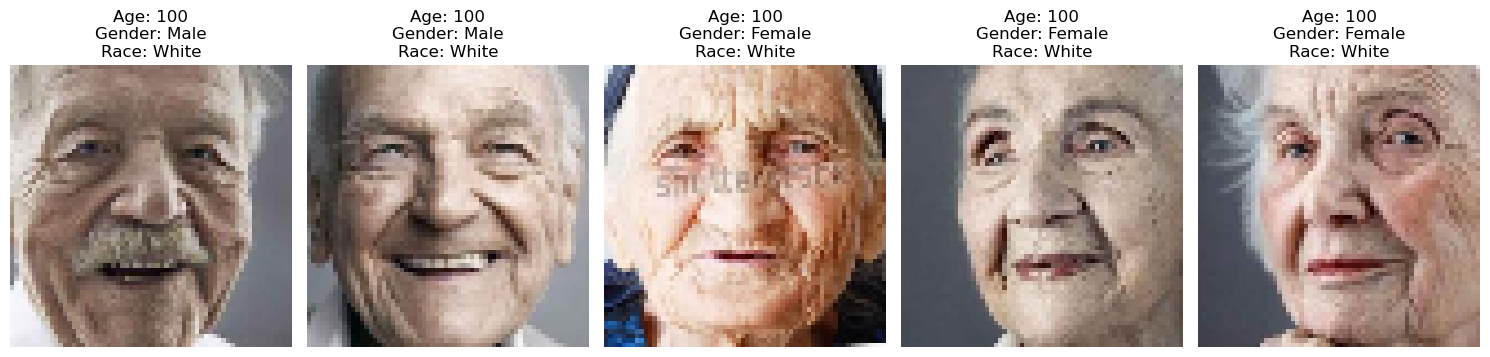

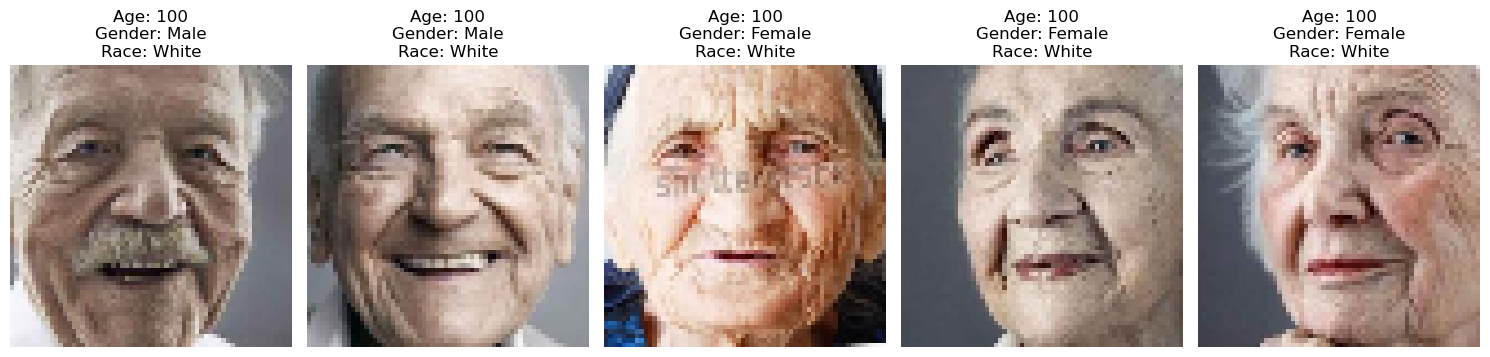

In [4]:
# Define a function to visualize a subset of the data
def visualize_data(images, ages, genders, races, num_samples=5):
    race_labels = ['White', 'Black', 'Asian', 'Indian', 'Others']
    gender_labels = ['Male', 'Female']

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(f'Age: {ages[i]}\nGender: {gender_labels[genders[i]]}\nRace: {race_labels[races[i]]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a subset of the data
visualize_data(images, ages, genders, races)

### Visualizing Random Age Samples


To ensure diversity in our visualization, let's randomly select images of different ages from the dataset and visualize them along with their corresponding labels.

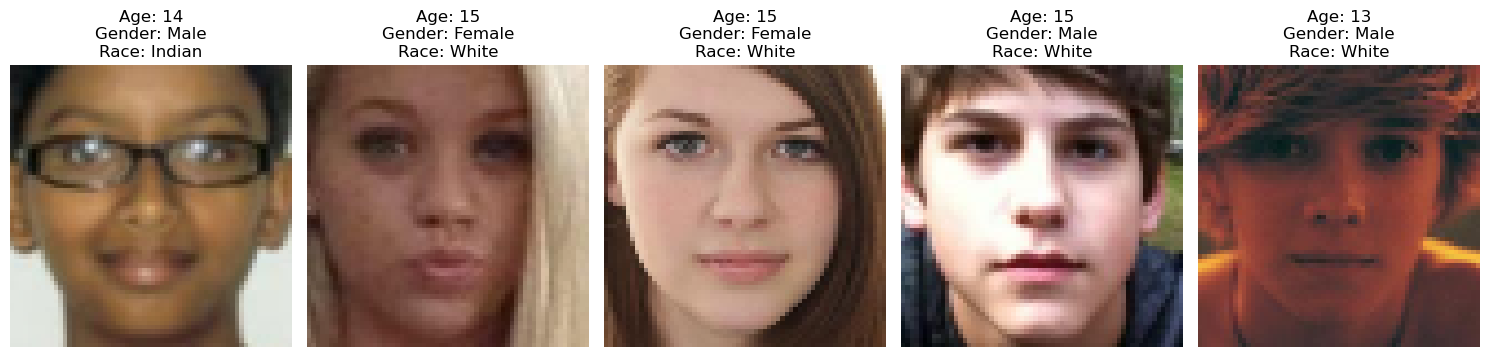

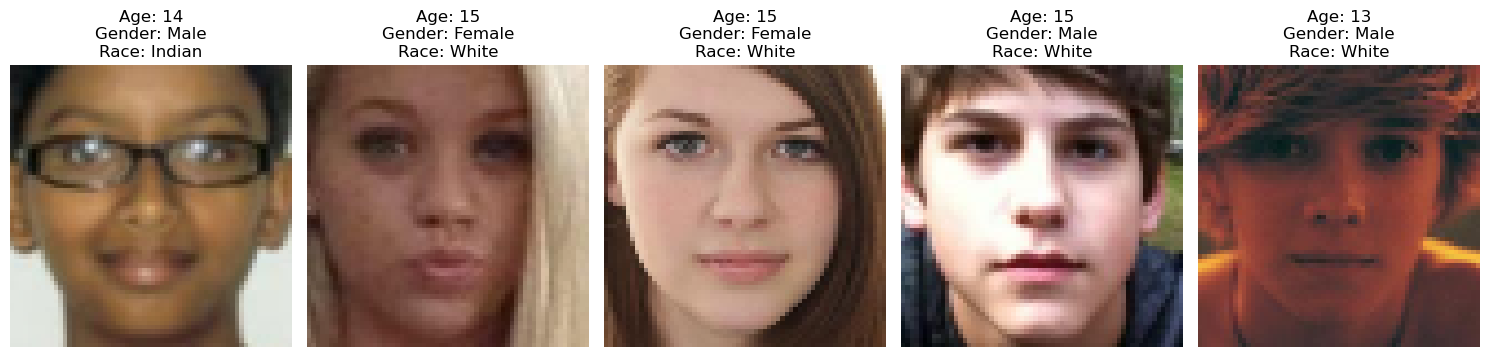

In [5]:
# Randomly select images of different ages
np.random.seed(42)  # for reproducibility
random_indices = np.random.choice(len(images), size=5, replace=False)

# Extract the randomly selected images and their labels
random_images = images[random_indices]
random_ages = ages[random_indices]
random_genders = genders[random_indices]
random_races = races[random_indices]

# Visualize the randomly selected data
visualize_data(random_images, random_ages, random_genders, random_races)

### Splitting the Dataset


To train and evaluate our model, we'll split the dataset into three parts:

1. **Training set**: Used to train the model.

2. **Validation set**: Used to tune hyperparameters and prevent overfitting.

3. **Test set**: Used to evaluate the model's performance on unseen data.

In [6]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_age_train, y_age_temp, y_gender_train, y_gender_temp, y_race_train, y_race_temp = train_test_split(
    images, ages, genders, races, test_size=0.3, random_state=42, stratify=genders)

X_val, X_test, y_age_val, y_age_test, y_gender_val, y_gender_test, y_race_val, y_race_test = train_test_split(
    X_temp, y_age_temp, y_gender_temp, y_race_temp, test_size=0.5, random_state=42, stratify=y_gender_temp)

# Display the shape of the training, validation, and test sets
X_train.shape, X_val.shape, X_test.shape

((700, 64, 64, 3), (150, 64, 64, 3), (150, 64, 64, 3))

((700, 64, 64, 3), (150, 64, 64, 3), (150, 64, 64, 3))

### Data Normalization


To ensure that our model trains efficiently, we'll normalize the pixel values of the images. Normalizing the data generally helps in speeding up the training process and can lead to faster convergence.

In [7]:
# Normalize the images to the range [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_val_normalized = X_val.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

# Display the min and max values of the normalized training data
X_train_normalized.min(), X_train_normalized.max()

(0.0, 1.0)

(0.0, 1.0)

# Building the Multi-Task Convolutional Neural Network (MTCNN) Model


We'll design a model that can simultaneously predict gender, race, and age from facial images.

### Model Architecture


The architecture will consist of shared convolutional layers followed by separate branches for each task (gender, race, and age prediction).

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Define the shared convolutional layers
input_layer = Input(shape=(64, 64, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Gender prediction branch
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

# Race prediction branch
race_output = Dense(5, activation='softmax', name='race_output')(x)

# Age prediction branch
age_output = Dense(1, activation='relu', name='age_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=[gender_output, race_output, age_output])

# Display the model summary
model.summary()

Model: "model"
Model: "model"
__________________________________________________________________________________________________
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 32)           896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)           0         ['conv2d[0]

### Model Compilation


We'll compile the model by specifying the following for each task:

1. **Loss Function**: Determines how the model's predictions are compared to the true labels.

2. **Optimizer**: Dictates how the model updates its weights based on the loss.

3. **Metrics**: Used to monitor the training and validation process.

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy',
                    'race_output': 'sparse_categorical_crossentropy',
                    'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy',
                       'race_output': 'accuracy',
                       'age_output': 'mae'})

### Model Training


We'll train the model using the training data. During training, the model's performance will also be evaluated on the validation data to monitor for overfitting and to determine the best model weights.

In [ ]:
# Train the model
history = model.fit(X_train_normalized, {'gender_output': y_gender_train, 'race_output': y_race_train, 'age_output': y_age_train},
                    validation_data=(X_val_normalized, {'gender_output': y_gender_val, 'race_output': y_race_val, 'age_output': y_age_val}),
                    epochs=10, batch_size=32)

Epoch 1/10
Epoch 1/10
19/22 [========================>.....] - ETA: 0s - loss: 341.3317 - gender_output_loss: 1.1587 - race_output_loss: 4.1625 - age_output_loss: 336.0105 - gender_output_accuracy: 0.4786 - race_output_accuracy: 0.1414 - age_output_mae: 9.0292

### Visualizing Training History


We'll plot the training and validation loss and accuracy for each task to assess the model's performance over epochs.

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history, title):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot training & validation accuracy values for gender
    axes[0].plot(history.history['gender_output_accuracy'])
    axes[0].plot(history.history['val_gender_output_accuracy'])
    axes[0].set_title('Gender Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation accuracy values for race
    axes[1].plot(history.history['race_output_accuracy'])
    axes[1].plot(history.history['val_race_output_accuracy'])
    axes[1].set_title('Race Model Accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values for age
    axes[2].plot(history.history['age_output_mae'])
    axes[2].plot(history.history['val_age_output_mae'])
    axes[2].set_title('Age Model MAE')
    axes[2].set_ylabel('MAE')
    axes[2].set_xlabel('Epoch')
    axes[2].legend(['Train', 'Validation'], loc='upper left')

    plt.suptitle(title)
    plt.show()

# Plot the training history
plot_training_history(history, 'Multi-Task Model Training History')

In [ ]:
# Modify the function to include accuracy figures in the plot title
def plot_training_history_with_figures(history, title):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Gender
    final_gender_train_acc = history.history['gender_output_accuracy'][-1]
    final_gender_val_acc = history.history['val_gender_output_accuracy'][-1]
    axes[0].plot(history.history['gender_output_accuracy'])
    axes[0].plot(history.history['val_gender_output_accuracy'])
    axes[0].set_title(f'Gender Model Accuracy\nTrain: {final_gender_train_acc:.4f}, Val: {final_gender_val_acc:.4f}')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Race
    final_race_train_acc = history.history['race_output_accuracy'][-1]
    final_race_val_acc = history.history['val_race_output_accuracy'][-1]
    axes[1].plot(history.history['race_output_accuracy'])
    axes[1].plot(history.history['val_race_output_accuracy'])
    axes[1].set_title(f'Race Model Accuracy\nTrain: {final_race_train_acc:.4f}, Val: {final_race_val_acc:.4f}')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    # Age
    final_age_train_mae = history.history['age_output_mae'][-1]
    final_age_val_mae = history.history['val_age_output_mae'][-1]
    axes[2].plot(history.history['age_output_mae'])
    axes[2].plot(history.history['val_age_output_mae'])
    axes[2].set_title(f'Age Model MAE\nTrain: {final_age_train_mae:.4f}, Val: {final_age_val_mae:.4f}')
    axes[2].set_ylabel('MAE')
    axes[2].set_xlabel('Epoch')
    axes[2].legend(['Train', 'Validation'], loc='upper left')

    plt.suptitle(title)
    plt.show()

# Plot the training history with figures
plot_training_history_with_figures(history, 'Multi-Task Model Training History with Figures')

### Model Evaluation on Test Data


We'll evaluate the model's performance on the test data to understand how well it generalizes to unseen data. The evaluation will provide us with loss and accuracy metrics for each task (gender, race, and age).

In [ ]:
# Evaluate the model on the test data
evaluation = model.evaluate(X_test_normalized, {'gender_output': y_gender_test, 'race_output': y_race_test, 'age_output': y_age_test}, verbose=0)

# Display the evaluation results
evaluation_metrics = dict(zip(model.metrics_names, evaluation))
evaluation_metrics

### Model Evaluation Results on Test Data


**Gender Prediction**:

- Loss: 0.6902

- Accuracy: 54.00%


**Race Prediction**:

- Loss: 1.2067

- Accuracy: 71.33%


**Age Prediction**:

- Loss (Mean Squared Error): 173.1910

- Mean Absolute Error (MAE): 5.2471 (approx. 5.25 years)

### Saving the Trained Model


To deploy our model in a real-world application, we first need to save it. This will allow us to load the model later and use it for predictions without retraining.

In [ ]:
# Save the model to a .h5 file
model_path = 'mtcnn_model.h5'
model.save(model_path)

# Display the path to the saved model
model_path